# Lab 6: MNIST and CNN Model

## Objective
<hr>

Build, train, and evaluate a Convolutional Neural Network (CNN) for handwritten digit recognition using the MNIST dataset. Also, preprocess data, visualize results, and upload the work to GitHub for review.

# 1. Download the MNIST Dataset

In [94]:
import torch
from torchvision.datasets import MNIST

# download dataset, save in current directory
train_dataset = MNIST(root='.', train=True, download=True)

# 2. Prepare the Data

## 2.1 Introduce the MNIST Dataset
<hr>

The MNIST Dataset is a collection of handwritten digits used to test and train image classification algorithms in machine learning. There are 70,000 of these images in total. 60,000 belong to the training set. 10,000 belong to the test set. There are 10 classes, which represent the digits from 0 to 9. The image dimensions are 28 by 28 pixels.

## 2.2 Create a Dataset and DataLoader
<hr>

In [95]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# dataloaders for batching
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)

## 2.3 Preprocess the Data
<hr>

In [103]:
from torchvision import transforms
from torch.utils.data import random_split, Subset

# define transformation
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307), (0.3081))
])

# load MNIST dataset, apply transforms
full_dataset = MNIST(root='.', transform=data_transforms)

# split dataset into train (90%) and valid (10%)
train_size = int(0.9*len(full_dataset))
valid_size = len(full_dataset) - train_size
train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

train_subset = Subset(train_dataset, range(1000)) # use first 1000 samples for training
valid_subset = Subset(valid_dataset, range(100))  # use first 100 samples for training

# dataloaders
train_loader = DataLoader(train_subset, BATCH_SIZE, shuffle=True, drop_last=False)
valid_loader = DataLoader(valid_subset, BATCH_SIZE, shuffle=True, drop_last=False)

Preprocessing steps are necessary because the MNIST images are in a format which is not compatible with PyTorch models. In this case, MNIST images are in PIL (Python Imaging Library) format. Therefore, ToTensor() is used to convert the PIL images into PyTorch tensors. Also, normalization uses the mean (0.1307) and standard deviation (0.3081) of the MNIST training. This prevents the model from developing biased results by features with larger ranges, stabilizing and speeding up convergence during training.

In general, preprocessing data is important to ensure compatibility with the model and improving efficiency. The data is transformed into a suitable format for training and preventing issues caused by large-scale inputs or inconsistent feature distribution.

## 2.4 Visualize the Processed Data
<hr>

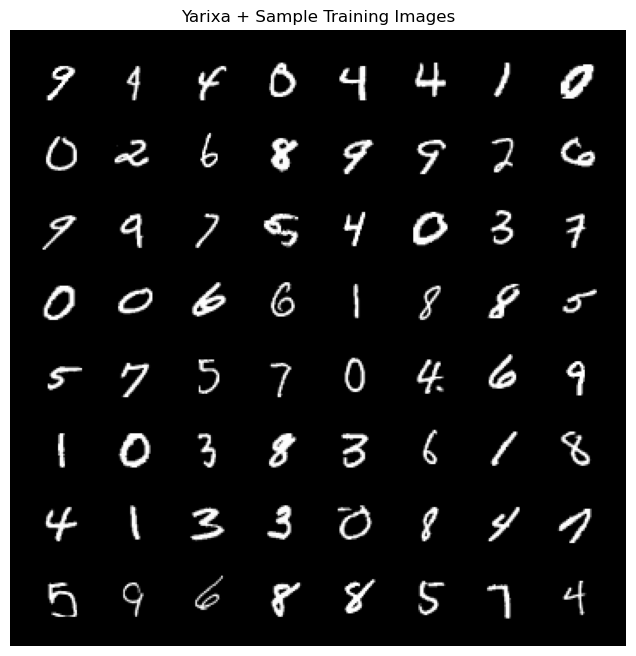

In [97]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# plot samples
sample_batch = next(iter(train_loader))

# visualization
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Yarixa + Sample Training Images')

# make grid from sample batch
plt.imshow(np.transpose(make_grid(sample_batch[0], padding=15, normalize=True), (1,2,0)))

# 3. Build a CNN Model

## 3.1 Define the Model Structure
<hr>

In [98]:
from torch import nn

class cnn_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3), padding=1),  # 1 input channel (grayscale) - 32 output channels (feature maps) - Kernel size of 3x3 with padding
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                 # Kernel size of 2x2 (reduces dimensions by half)
            nn.Conv2d(32, 64, (3, 3), padding=1), # 32 input channels (from the previous conv layer) - 64 output channels - Kernel size of 3x3 with padding
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                 # Max Pooling Layer with Kernel size of 2x2
            nn.Flatten(),                         # Flatten Layer: Converts the multi-dimensional feature maps into a 1D vector
            nn.Linear(64*7*7, 128),               # Fully Connected (Linear) Layer: Connects the flattened features to 128 neurons
            nn.ReLU(),
            nn.Linear(128, 10)                    # Output Layer: Maps the 128 neurons to 10 output neurons (one for each digit class)
        )

    def forward(self, x):
        out = self.main(x)
        return out

In [99]:
model = cnn_model()

## 3.2 Set Up the Trainer
<hr>

In [100]:
from torch import optim

def trainer(model, criterion, optimizer, train_loader, valid_loader, epochs=5, verbose=True):
    """
    train and validate pytorch model

    args:
        model: pytorch model to train
        criterion: loss function
        optimizer: optimizer for updating weights
        train_loader: dataloader for training data
        valid_loader: dataloader for validation data
        epochs: number of epochs for training
        verbose: if true, print progress for each epoch

    returns:
        a dictionary containing training loss, validation loss, and validation accuracy
    """
    train_loss, valid_loss, valid_accuracy = [], [], []

    for epoch in range(epochs):
        train_batch_loss = 0
        valid_batch_loss = 0
        valid_batch_acc = 0

        # training
        model.train()
        for X, y in train_loader:
            optimizer.zero_grad()           # reset gradients
            y_hat = model(X)                # forward pass: compute the model's prediction
            loss = criterion(y_hat, y)      # compute loss between predicted values and actual values
            loss.backward()                 # backpropagation: compute gradients
            optimizer.step()                # update model parameters using optimizer
            train_batch_loss += loss.item() # accumulate batch loss
        train_loss.append(train_batch_loss / len(train_loader)) # compute average training loss for this epoch

        # validation
        model.eval()                            # set the model to evaluation mode (disables dropout/batchnorm layers)
        with torch.no_grad():                   # stops computation graph tracking, saves memory and time
            for X, y in valid_loader:
                y_hat = model(X)                # forward pass: compute predictions for validation set
                loss = criterion(y_hat, y)      # compute validation loss
                valid_batch_loss += loss.item() # accumulate validation batch loss
                y_hat_labels = torch.argmax(y_hat, dim=1) # get predicted class
                valid_batch_acc += (y_hat_labels == y).float().mean().item() # accuracy
                
        valid_loss.append(valid_batch_loss / len(valid_loader)) # compute average validation loss for this epoch
        valid_accuracy.append(valid_batch_acc / len(valid_loader)) # compute average validation accuracy for this epoch

        # print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")

    results = {"train_loss": train_loss,
               "valid_loss": valid_loss,
               "valid_accuracy": valid_accuracy}

    return results
    

## 3.3 Summarize the Model
<hr>

In [101]:
from torchsummary import summary

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 128]         401,536
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 1.61
Estimated T

## 3.4 Train the Model
<hr>

In [102]:
# intialize model
model = cnn_model()

# define loss function
criterion = nn.CrossEntropyLoss()

# define optimizer
optimizer = optim.Adam(model.parameters())

# train the model using the trainer function
results = trainer(model, criterion, optimizer, train_loader, valid_loader, epochs=50)

Epoch 1: Train Loss: 1.525. Valid Loss: 0.762. Valid Accuracy: 0.79.
Epoch 2: Train Loss: 0.593. Valid Loss: 0.542. Valid Accuracy: 0.87.
Epoch 3: Train Loss: 0.379. Valid Loss: 0.414. Valid Accuracy: 0.88.
Epoch 4: Train Loss: 0.239. Valid Loss: 0.317. Valid Accuracy: 0.90.
Epoch 5: Train Loss: 0.196. Valid Loss: 0.309. Valid Accuracy: 0.89.
Epoch 6: Train Loss: 0.147. Valid Loss: 0.268. Valid Accuracy: 0.89.
Epoch 7: Train Loss: 0.094. Valid Loss: 0.199. Valid Accuracy: 0.94.
Epoch 8: Train Loss: 0.061. Valid Loss: 0.252. Valid Accuracy: 0.91.
Epoch 9: Train Loss: 0.043. Valid Loss: 0.275. Valid Accuracy: 0.92.
Epoch 10: Train Loss: 0.041. Valid Loss: 0.363. Valid Accuracy: 0.91.
Epoch 11: Train Loss: 0.031. Valid Loss: 0.193. Valid Accuracy: 0.93.
Epoch 12: Train Loss: 0.015. Valid Loss: 0.203. Valid Accuracy: 0.93.
Epoch 13: Train Loss: 0.017. Valid Loss: 0.196. Valid Accuracy: 0.94.
Epoch 14: Train Loss: 0.011. Valid Loss: 0.233. Valid Accuracy: 0.91.
Epoch 15: Train Loss: 0.008. 

# 4. Visualize and Evaluation

## 4.1 Training Loss Over Epochs
<hr>

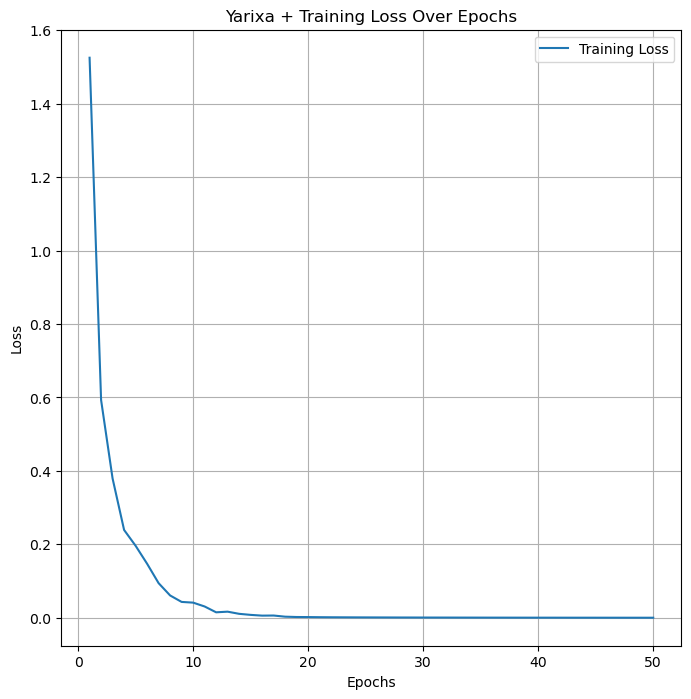

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.plot(range(1, len(results['train_loss']) + 1), results['train_loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Yarixa + Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

The graph shows a significant decrease for the training loss at the beginning. It becomes more constant as the value decreaseas. The lack of sudden increase or decrease means that the model is learning in a stable manner, thus it is effective in optimizing its training efficiency.

## 4.2 Validation Loss Over Epochs
<hr>

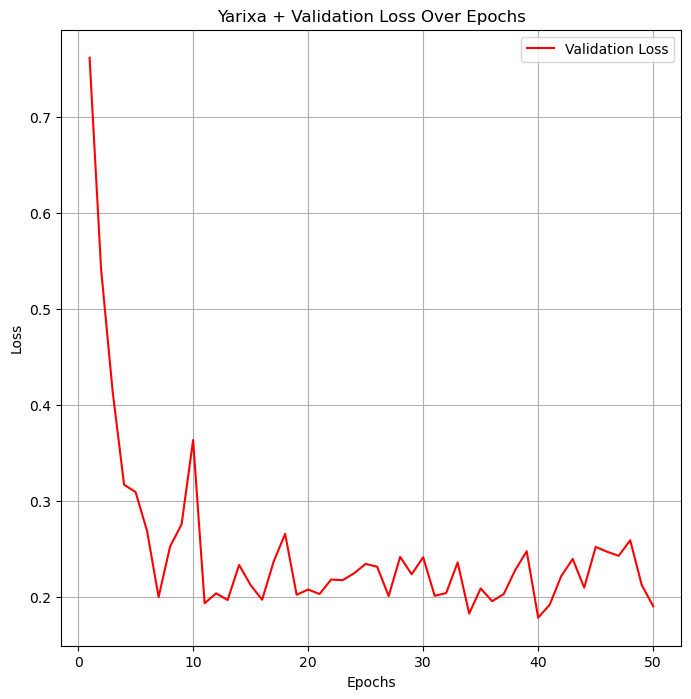

In [109]:
plt.figure(figsize=(8, 8))
plt.plot(range(1, len(results['valid_loss']) + 1), results['valid_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Yarixa + Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Similar to the previous graph, this one also shows a steady decrease followed by a constant flow. This could mean that the model does not overfit the data.

## 4.3 Predicted Result vs. Actual Results
<hr>

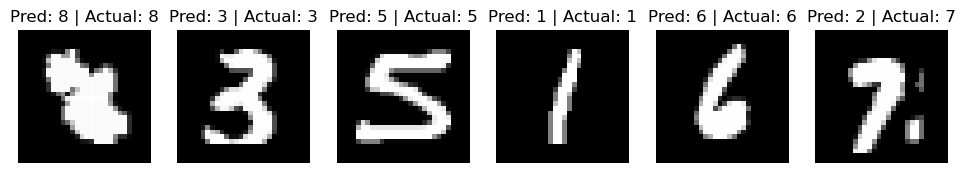

In [129]:
def pred_vs_actual(model, valid_loader, num_samples=5):
    model.eval()
    with torch.no_grad():
        data_iter = iter(valid_loader)
        images, labels = next(data_iter)
        predictions = model(images.to(device)).argmax(dim=1) # get model predictions
        
        # plot images
        plt.figure(figsize=(12, 8))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i+1)
            plt.imshow(images[i].cpu().squeeze(), cmap='gray')
            plt.title(f"Pred: {predictions[i].item()} | Actual: {labels[i].item()}")
            plt.axis('off')
        plt.show()

pred_vs_actual(model, valid_loader, num_samples=6)

This visualization shows the a sample of predicted vs. actual results. The model correctly classifies the majority of the samples, suggesting that the model is performing well. The last sample predicts 2 and the actual data is 7. This misclassfication could be becuase of the disconnected features which may be challenging for the model to identify or misidentifies as part of the 'number'.

## 4.4 Validation Accuracy Over Epochs
<hr>

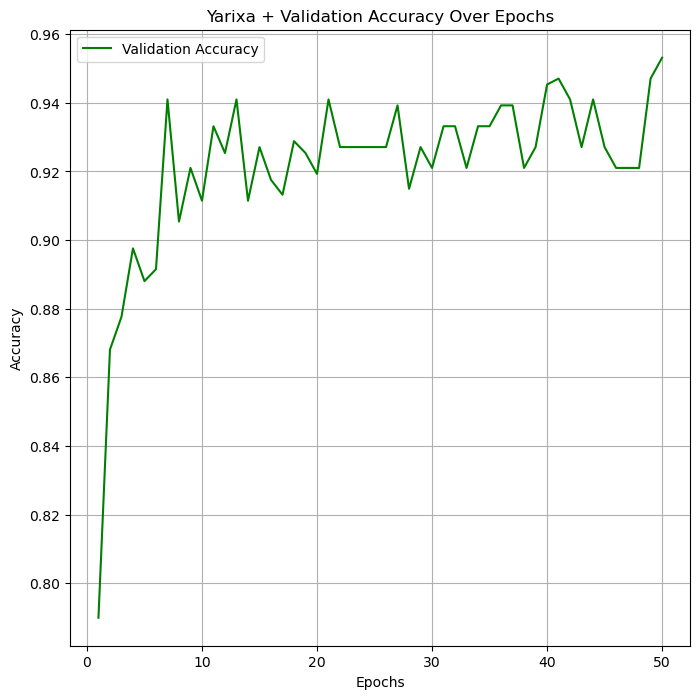

In [123]:
plt.figure(figsize=(8, 8))
plt.plot(range(1, len(results['valid_accuracy']) + 1), results['valid_accuracy'], label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Yarixa + Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

The validation accuracy shows a significant increase and stabilizes around 94%. This shows that the model has achieved good generalization with minimal improvement on the set. Further training might not necessarily improve the model.

## 4.5 Misclassified Examples
<hr>

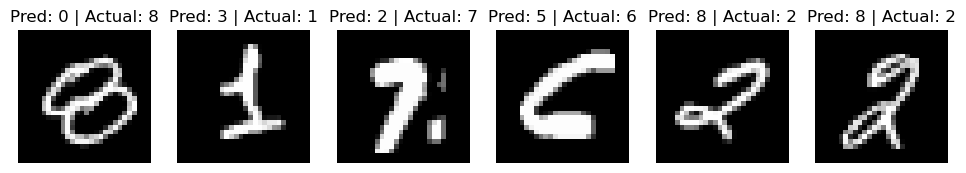

In [130]:
# function visualizes misclassified images
def visualize_misclassified(model, valid_loader, num_samples=5):
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []
    with torch.no_grad():
        for images, labels in valid_loader:
            predictions = model(images.to(device)).argmax(dim=1)
            misclassified_indices = (predictions != labels)
            misclassified_images.extend(images[misclassified_indices])
            misclassified_labels.extend(labels[misclassified_indices])
            misclassified_preds.extend(predictions[misclassified_indices])

            if len(misclassified_images) >= num_samples:
                break

    # plot misclassified images
    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(misclassified_images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"Pred: {misclassified_preds[i].item()} | Actual: {misclassified_labels[i].item()}")
        plt.axis('off')
    plt.show()

visualize_misclassified(model, valid_loader, num_samples=6)

Looking at these misclassfied examples, it can be discerned what numbers that model commonly misclassifies. Also, it can be observed which distinct features contribute to this misclassification, such as curvature, line thickness, line flow (meaning the direction a line seemingly was drawn in), and random features such as in the third image where two white spots are located separate to the main figure.

# 5. Save Model

In [131]:
torch.save(model, "mnist_model.pt")